In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install scikit-surprise

In [ ]:
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering, Reader #Matrix Factorization-based algorithms SVDpp, SVD, NMF
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
import math
from collections import defaultdict
import csv
from sklearn.metrics import ndcg_score
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [ ]:
file_path_train = '/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/created/training_data.csv'
file_path_test = '/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/created/testing_data.csv'
traindf = pd.read_csv(file_path_train)
testdf = pd.read_csv(file_path_test)

def convert_traintest_dataframe_forsurprise(training_dataframe, testing_dataframe):
    reader = Reader(rating_scale=(0, 5))
    trainset = Dataset.load_from_df(training_dataframe[['userId', 'movieId', 'rating']], reader)
    testset = Dataset.load_from_df(testing_dataframe[['userId', 'movieId', 'rating']], reader)
    trainset = trainset.construct_trainset(trainset.raw_ratings)
    testset = testset.construct_testset(testset.raw_ratings)
    return trainset, testset

trainset, testset = convert_traintest_dataframe_forsurprise(traindf, testdf)

In [ ]:
def get_top_n(predictions, n):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    org_ratings = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        org_ratings[uid].append((iid, true_r))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n, org_ratings

In [ ]:
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    precision = (sum(prec for prec in precisions.values()) / len(precisions))
    recall = (sum(rec for rec in recalls.values()) / len(recalls))

    return precision, recall

In [ ]:
def recommendation(algo, trainset, testset):
  # Train the algorithm on the trainset, and predict ratings for the testset
  start_fit = time.time()
  algo.fit(trainset)
  end_fit = time.time()
  fit_time = end_fit - start_fit

  # Predictions on testing set
  start_test = time.time()
  test_predictions = algo.test(testset)
  end_test = time.time()
  test_time = end_test - start_test

  test_rmse = accuracy.rmse(test_predictions)
  test_mae = accuracy.mae(test_predictions)

  top_n, org_ratings = get_top_n(test_predictions, 5)

  precision, recall = precision_recall_at_k(test_predictions)

  f_measure = (2*precision*recall)/(precision+recall)

  return (test_rmse, test_mae, fit_time, test_time, precision, recall, f_measure,test_predictions)

In [ ]:
# basic collaborative filtering algorithm taking into account a baseline rating.
sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)

test_rmse, test_mae, test_predictions, fit_time, test_time, precision, recall, f_measure = recommendation(algo,trainset,testset)
print(test_rmse)
print(test_mae)
print(fit_time)
print(test_time)
print(precision)
print(recall)
print(f_measure)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8650
MAE:  0.6589
0.8649997105627933
0.6589008987664187
7.530039548873901
0.8286338797814236
0.4040757407513184
0.5432436694046621
0.9630252203664312


In [ ]:
algo = CoClustering(2,5,50)

test_rmse, test_mae, test_predictions, fit_time, test_time, precision, recall, f_measure= recommendation(algo,trainset,testset)
print(test_rmse)
print(test_mae)
print(fit_time)
print(test_time)
print(precision)
print(recall)
print(f_measure)

RMSE: 0.9546
MAE:  0.7360
0.9545560685934006
0.735972142055691
0.11569023132324219
0.7859016393442648
0.3834237480073447
0.5153969209630872
0.9551266220406122


In [ ]:
surprise_df = pd.DataFrame(columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure'])

In [ ]:
# Iterate over all algorithms
for algorithm in [KNNBasic(), SVD(), SVDpp(), SlopeOne(), NMF(), KNNBaseline(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    results = recommendation(algorithm,trainset,testset) 
    
    name =str(algorithm).split(' ')[0].split('.')[-1]
    print("Algorithm:", name)
    df = pd.DataFrame([[name, results[0], results[1], results[2], results[3], results[4], results[5], results[6] ]], columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure'])
    surprise_df = pd.concat([df, surprise_df], ignore_index=True)
surprise_df.sort_values(by='test_rmse', ascending=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9601
MAE:  0.7332
Algorithm: KNNBasic
RMSE: 0.8891
MAE:  0.6798
Algorithm: SVD
RMSE: 0.8770
MAE:  0.6695
Algorithm: SVDpp
RMSE: 0.9176
MAE:  0.6969
Algorithm: SlopeOne
RMSE: 0.9385
MAE:  0.7157
Algorithm: NMF
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8893
MAE:  0.6764
Algorithm: KNNBaseline
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9104
MAE:  0.6934
Algorithm: KNNWithMeans
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9085
MAE:  0.6872
Algorithm: KNNWithZScore
Estimating biases using als...
RMSE: 0.8836
MAE:  0.6792
Algorithm: BaselineOnly
RMSE: 0.9568
MAE:  0.7392
Algorithm: CoClustering


,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure
9,KNNBasic,0.960121,0.733222,0.122788,1.668324,0.783989,0.430059,0.555434
0,CoClustering,0.956814,0.739207,2.258491,0.123720,0.779863,0.388951,0.519036
5,NMF,0.938453,0.715723,5.760271,0.161405,0.781885,0.389732,0.520180
6,SlopeOne,0.917607,0.696909,4.817988,6.182428,0.786585,0.397853,0.528428
3,KNNWithMeans,0.910415,0.693436,0.145944,1.788284,0.778852,0.386358,0.516501
2,KNNWithZScore,0.908513,0.687232,0.176858,2.035167,0.792596,0.394887,0.527142
4,KNNBaseline,0.889314,0.676437,0.325069,2.170254,0.797186,0.413553,0.544591
8,SVD,0.889125,0.679751,4.594184,0.178189,0.811585,0.398311,0.534366
1,BaselineOnly,0.883553,0.679160,0.212841,0.243410,0.816393,0.405654,0.541997
7,SVDpp,0.876996,0.669508,502.212007,9.494676,0.821011,0.397955,0.536070


In [ ]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False  # compute  similarities between items
               }
algo = KNNBaseline(sim_options=sim_options)

results = recommendation(algo,trainset,testset)
df = pd.DataFrame([['KNNBaseline (pearson_baseline)', results[0], results[1], results[2], results[3], results[4], results[5], results[6] ]], columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure'])
surprise_df = pd.concat([df, surprise_df], ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8650
MAE:  0.6589


In [ ]:
bsl_options = {'name': 'sgd',
               'learning_rate': .00005,  # compute  similarities between items
               }
algo = BaselineOnly(bsl_options=bsl_options)

results = recommendation(algo,trainset,testset)
df = pd.DataFrame([['sgd', results[0], results[1], results[2], results[3], results[4], results[5], results[6]]], columns= ['Algorithm', 'test_rmse', 'test_mae', 'fit_time', 'test_time', 'Precision', 'Recall', 'F-measure'])
surprise_df = pd.concat([df, surprise_df], ignore_index=True)

Estimating biases using als...
RMSE: 0.8836
MAE:  0.6792


In [ ]:
surprise_df.sort_values(by='test_rmse')

,Algorithm,test_rmse,test_mae,fit_time,test_time,Precision,Recall,F-measure
1,KNNBaseline (pearson_baseline),0.865000,0.658901,9.634645,7.583526,0.828634,0.404076,0.543244
9,SVDpp,0.876996,0.669508,502.212007,9.494676,0.821011,0.397955,0.536070
0,sgd,0.883553,0.679160,0.216942,0.101524,0.816393,0.405654,0.541997
3,BaselineOnly,0.883553,0.679160,0.212841,0.243410,0.816393,0.405654,0.541997
10,SVD,0.889125,0.679751,4.594184,0.178189,0.811585,0.398311,0.534366
6,KNNBaseline,0.889314,0.676437,0.325069,2.170254,0.797186,0.413553,0.544591
4,KNNWithZScore,0.908513,0.687232,0.176858,2.035167,0.792596,0.394887,0.527142
5,KNNWithMeans,0.910415,0.693436,0.145944,1.788284,0.778852,0.386358,0.516501
8,SlopeOne,0.917607,0.696909,4.817988,6.182428,0.786585,0.397853,0.528428
7,NMF,0.938453,0.715723,5.760271,0.161405,0.781885,0.389732,0.520180


In [ ]:
surprise_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/created/Surprise_results.csv')

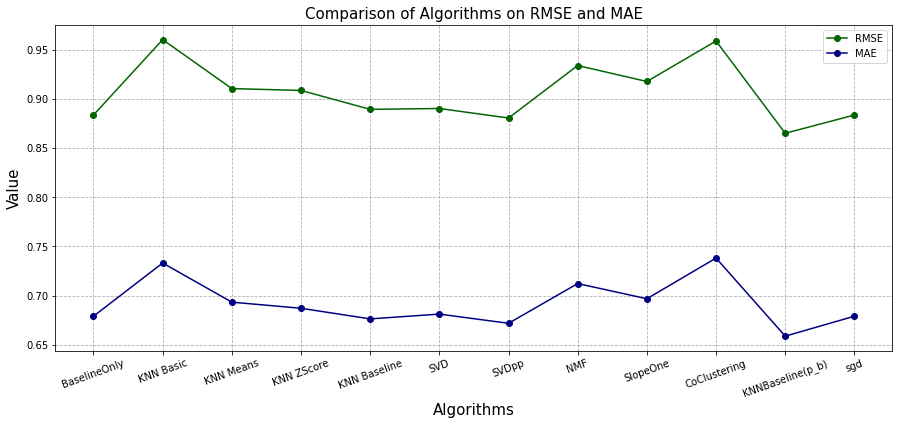

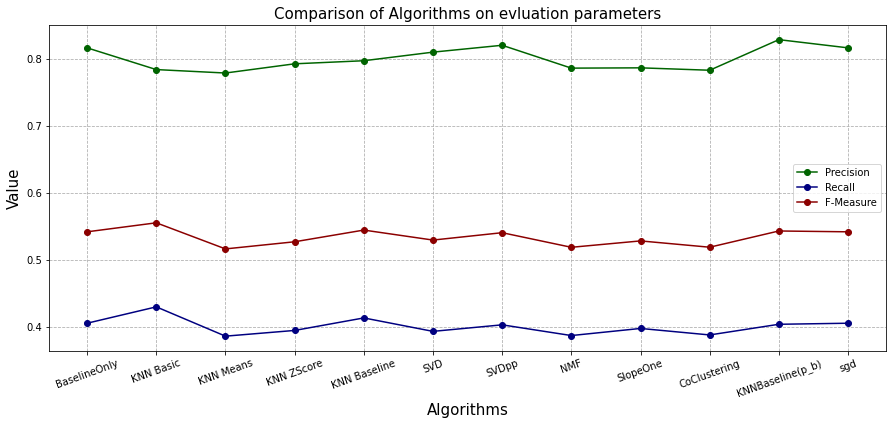

In [ ]:
x_algo = ['BaselineOnly','KNN Basic', 'KNN Means', 'KNN ZScore','KNN Baseline', 'SVD', 'SVDpp', 'NMF', 'SlopeOne', 'CoClustering','KNNBaseline(p_b)','sgd']

rmse = [0.883553, 0.960121,0.910415, 0.908513, 0.889314, 0.890175 ,0.880511, 0.933850, 0.917607,0.958728, 0.86500,0.883553]
mae = [0.679160, 0.733222, 0.693436,0.687232, 0.676437,0.681319, 0.671955, 0.712330,0.696909,0.738220, 0.658901,0.679160]
precision = [0.816393,0.783989,0.778852 ,0.792596 , 0.797186,0.810000 ,0.820246 ,0.786148 , 0.786585 , 0.783005, 0.828634,0.816393]
recall = [0.405654,0.430059 ,0.386358 ,0.394887 ,0.413553 ,0.393502 ,0.403249 ,0.387261 ,0.397853, 0.388160, 0.404076,0.405654]
f_measure = [0.541997,0.555434 ,0.516501 ,0.527142 ,0.544591 , 0.529682, 0.540686, 0.518906, 0.528428,0.519023 , 0.543244,0.541997]

plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on RMSE and MAE', loc='center', fontsize=15)
plt.plot(x_algo, rmse, label='RMSE', color='darkgreen', marker='o')
plt.plot(x_algo, mae, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.xticks(rotation=20)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()

plt.figure(figsize=(15,6))
plt.title('Comparison of Algorithms on evluation parameters', loc='center', fontsize=15)
plt.plot(x_algo, precision, label='Precision', color='darkgreen', marker='o')
plt.plot(x_algo, recall, label='Recall', color='navy', marker='o')
plt.plot(x_algo, f_measure, label='F-Measure', color='darkred', marker='o')
# plt.plot(x_algo, ndcg, label='NDCG', color='purple', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.xticks(rotation=20)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()

In [ ]:
def ratingprediction(algo, trainset, testset):
  # Train the algorithm on the trainset, and predict ratings for the testset
  algo.fit(trainset)

  # Predictions on testing set
  test_predictions = algo.test(testset)
  return test_predictions

In [ ]:
algo = KNNBasic()
test_knn_basic_pred = ratingprediction(algo, trainset, testset)

algo = SVD()
test_svd_pred = ratingprediction(algo, trainset, testset)

algo = SVDpp()
test_svdpp_pred = ratingprediction(algo, trainset, testset)

algo = SlopeOne()
test_s1_pred = ratingprediction(algo, trainset, testset)

algo = NMF()
test_nmf_pred = ratingprediction(algo, trainset, testset)

algo = KNNBaseline()
test_knn_baseline_pred = ratingprediction(algo, trainset, testset)

algo = KNNWithMeans()
test_knn_means_pred = ratingprediction(algo, trainset, testset)

algo = KNNWithZScore()
test_knn_zscore_pred = ratingprediction(algo, trainset, testset)

algo = BaselineOnly()
test_baseline_pred = ratingprediction(algo, trainset, testset)

algo = CoClustering()
test_co_pred = ratingprediction(algo, trainset, testset)

algo = KNNBaseline(sim_options={'name': 'pearson_baseline','user_based': False})
test_knn_pb_pred = ratingprediction(algo, trainset, testset)

algo = BaselineOnly(bsl_options={'name': 'sgd','learning_rate': .00005})
test_sgd_pred = ratingprediction(algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [ ]:
test_pred_df = pd.DataFrame(columns= ['uid', 'iid', 'og_rating', 'knn_basic_rating', 'svd_rating', 'svdpp_rating', 's1_rating', 'nmf_rating','knn_baseline_rating',
                                      'knn_means_rating', 'zscore_rating', 'baseline_rating', 'co_rating','knn_pb_rating', 'sgd'])

In [ ]:
num_test = len(test_knn_means_pred)
print(num_test)

20168


In [ ]:
for i in range(num_test): 
  knn_basic = test_knn_basic_pred[i]
  svd = test_svd_pred[i]
  svdpp = test_svdpp_pred[i]
  s1 = test_s1_pred[i]
  nmf = test_nmf_pred[i]
  knn_baseline = test_knn_baseline_pred[i]
  knn_means = test_knn_means_pred[i]
  zscore = test_knn_zscore_pred[i]
  baseline = test_baseline_pred[i]
  co = test_co_pred[i]
  knn_pb = test_knn_pb_pred[i]
  sgd = test_sgd_pred[i]
  df = pd.DataFrame([[svd.uid, svd.iid, svd.r_ui, knn_basic.est, svd.est,
                      svdpp.est, s1.est, nmf.est,knn_baseline.est, knn_means.est, zscore.est,
                      baseline.est,co.est, knn_pb.est, sgd.est]], columns= ['uid', 'iid', 'og_rating', 'knn_basic_rating', 'svd_rating', 'svdpp_rating', 's1_rating', 'nmf_rating','knn_baseline_rating',
                                      'knn_means_rating', 'zscore_rating', 'baseline_rating', 'co_rating','knn_pb_rating', 'sgd'])
  # print(df)
  test_pred_df = pd.concat([df, test_pred_df], ignore_index=True)

In [ ]:
test_pred_df.head()

,uid,iid,og_rating,knn_basic_rating,svd_rating,svdpp_rating,s1_rating,nmf_rating,knn_baseline_rating,knn_means_rating,zscore_rating,baseline_rating,co_rating,knn_pb_rating,sgd
0,610,162350,3.5,3.542453,3.540262,3.083839,2.764698,3.533681,3.579107,3.515137,3.555868,3.616397,3.386622,3.596348,3.616397
1,610,161634,4.0,3.159750,3.683219,3.648862,3.065799,3.790273,3.399205,3.396754,3.361002,3.592904,2.699947,3.959127,3.592904
2,610,160836,3.0,3.502331,3.610568,3.588027,3.502331,3.502331,3.617315,3.502331,3.502331,3.617315,3.502331,3.617315,3.617315
3,610,152372,3.5,3.502331,3.610568,3.588027,3.502331,3.502331,3.617315,3.502331,3.502331,3.617315,3.502331,3.617315,3.617315
4,610,149406,3.5,3.391547,3.817691,3.836795,3.754779,4.111745,3.832703,3.805187,3.830558,3.677659,3.116613,3.884812,3.677659


In [ ]:
test_pred_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/created/test_prediction.csv')

In [ ]:
pred_data = test_pred_df
# num of rows:
T = pred_data.shape[0]
print(T)

20168


In [ ]:
knn_pb_wt = 0.05
svd_wt = 0.5
svdpp_wt = 0.3
sgd_wt = 0.02
baseline_wt = 0.02

In [ ]:
sqr_sum = 0
abs_sum = 0

for ind, row in pred_data.iterrows():
  org_r = row['og_rating']
  pred_r = knn_pb_wt*row['knn_pb_rating'] + svd_wt*row['svd_rating'] + svdpp_wt*row['svdpp_rating'] + sgd_wt*row['sgd'] + baseline_wt*row['baseline_rating']
  diff = np.abs(org_r - pred_r)
  # print(diff)
  abs_sum += diff
  sqr_sum += diff**2
rmse = np.sqrt(sqr_sum/T)
print("RMSE", rmse)
mae = abs_sum/T
print("MAE", mae)

RMSE 0.8314000035401449
MAE 0.6216161579955481


In [ ]:
sqr_sum = 0
abs_sum = 0
knn_pb_wt = 0.2
svdpp_wt = 0.3

for ind, row in pred_data.iterrows():
  org_r = row['og_rating']
  pred_r = knn_pb_wt*row['knn_pb_rating'] + svdpp_wt*row['svdpp_rating']
  diff = np.abs(org_r - pred_r)
  # print(diff)
  abs_sum += diff
  sqr_sum += diff**2
rmse = np.sqrt(sqr_sum/T)
print("RMSE", rmse)

mae = abs_sum/T
print("MAE", mae)

RMSE 0.8513999892470081
MAE 0.6500025783419279


In [ ]:
sqr_sum = 0
abs_sum = 0
svdpp_wt = 0.04
sgd_wt = 0.3

for ind, row in pred_data.iterrows():
  org_r = row['og_rating']
  pred_r = svdpp_wt*row['svdpp_rating'] + sgd_wt*row['sgd']
  diff = np.abs(org_r - pred_r)
  # print(diff)
  abs_sum += diff
  sqr_sum += diff**2
rmse = np.sqrt(sqr_sum/T)
print("RMSE", rmse)
mae = abs_sum/T
print("MAE", mae)

RMSE 0.8603794664329344
MAE 0.6609109480364935


In [ ]:
sqr_sum = 0
abs_sum = 0
sgd_wt = 0.3
knn_wt = 0.07

for ind, row in pred_data.iterrows():
  org_r = row['og_rating']
  pred_r = sgd_wt*row['sgd'] + knn_wt*row['knn_pb_rating']
  diff = np.abs(org_r - pred_r)
  # print(diff)
  abs_sum += diff
  sqr_sum += diff**2
rmse = np.sqrt(sqr_sum/T)
print("RMSE", rmse)
mae = abs_sum/T
print("MAE", mae)

RMSE 0.8600912691530499
MAE 0.6604151130503768


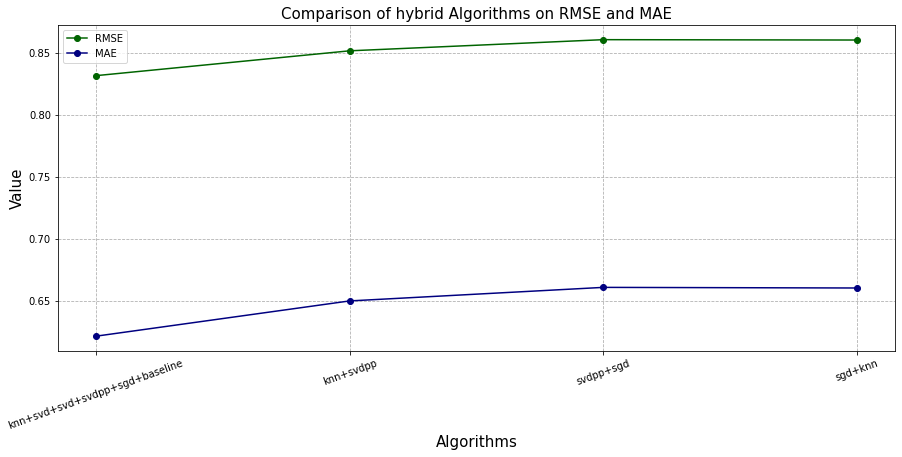

In [ ]:
x_algo = ['knn+svd+svd+svdpp+sgd+baseline','knn+svdpp', 'svdpp+sgd', 'sgd+knn']

rmse = [0.8314000035401449,0.8513999892470081, 0.8603794664329344, 0.8600912691530499]
mae = [0 0.650002578.6216161579955481,3419279, 0.6609109480364935,0.6604151130503768]

plt.figure(figsize=(15,6))
plt.title('Comparison of hybrid Algorithms on RMSE and MAE', loc='center', fontsize=15)
plt.plot(x_algo, rmse, label='RMSE', color='darkgreen', marker='o')
plt.plot(x_algo, mae, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.xticks(rotation=20)
plt.ylabel('Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')
plt.show()